In [4]:
from homologous_point_prediction.standard_pipeline import HomologousPointPipeline
from homologous_point_prediction.models.custom_layers import Patches, ProjectPoints
from homologous_point_prediction.models.helpers import load_model, save_model
from tensorflow.keras import Model
from homologous_point_prediction.models.att_9_cnn_transformer import get_model 
from tensorflow.keras.layers import Input
from homologous_point_prediction.data_processing.data_loader_multipoint import MultiPointDataLoader
from homologous_point_prediction.data_processing.helpers import random_augmentation, center_prostate, reverse_center_prostate
from homologous_point_prediction.data_processing.augmentation import rotate
from mri_histology_toolkit.data_loader import DataLoader
from mri_histology_toolkit.image import dimension_reduce
from mri_histology_toolkit.register import HumanControlPointPipeline
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
import matplotlib
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [120]:
image = np.ones((1, 512, 512, 1))
points = tf.ones((1, 32, 2)) * 256

In [13]:
test = np.array([[1,2], [3,4]])

In [17]:
np.repeat(test[np.newaxis, :, :], 3, axis=0)

array([[[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]]])

In [129]:
def random_augment(images, points, point_deviation=12):
    points = np.array(points)
    images = np.array(images)
    # batch_size, image dims
    x = np.linspace(16, 496, 8)
    xv, yv = np.meshgrid(x, x, sparse=False)
    coords = np.concatenate((xv.reshape((-1, 1)), yv.reshape((-1, 1))), axis=-1)
    coords = np.repeat(coords[np.newaxis, :, :], len(images), axis=0)
    rand = ((np.random.random_sample(coords.shape) * point_deviation * 2) - point_deviation)
    randomized_grid = coords + rand
    
    warped_image, flow_field = tfa.image.sparse_image_warp(images.astype(np.float32), coords.astype(np.float32), randomized_grid.astype(np.float32))
    
    # Gather new points
    ff = np.array(flow_field)
    starting_coord = np.repeat(np.arange(0, len(images), 1).reshape(-1, 1, 1), points.shape[1], axis=1)
    full_input_point_coords = np.concatenate((starting_coord, points), axis=-1).astype(int).reshape(-1, 3)
    offsets = np.array([ff[tuple(x)] for x in full_input_point_coords])
    inter_points = points.reshape(-1, 2) + offsets
    inter_points = inter_points.reshape(points.shape)
    
    return warped_image, (inter_points * (points != 0)).astype(int)

In [130]:
img, points = random_augment(image, points)

In [3]:
config = "/home/ruchtia/git/homologous_point_prediction/homologous_point_prediction/data_processing/metadata/multipoint_test_config.json"
test_data_loader = MultiPointDataLoader(config, num_points=100, warped_pair_rate=0.5)
model = load_model("./homologous_point_prediction/outputs/04-08-22|11:13:46/model")

In [4]:
(fixed, moving, fp), mp = test_data_loader[0]

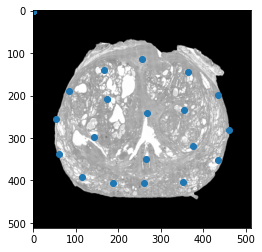

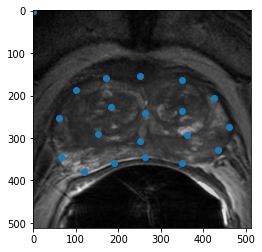

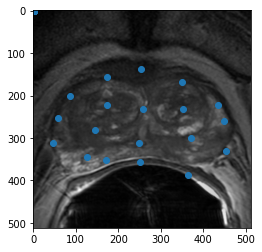

In [11]:
show_index = 1
plt.imshow(fixed[show_index], cmap="gray")
plt.scatter(fp[show_index, :, 1], fp[show_index, :, 0] )
plt.show()
plt.imshow(moving[show_index], cmap="gray")
plt.scatter(mp[show_index, :, 1], mp[show_index, :, 0] )
plt.show()

predicted_points = model.predict([fixed[show_index:show_index+1], moving[show_index:show_index+1], fp[show_index:show_index+1]])
plt.imshow(moving[show_index], cmap="gray")
plt.scatter(predicted_points[0, :, 1], predicted_points[0, :, 0] )

In [42]:
data_loader = DataLoader(config_path="/home/ruchtia/git/method_analysis/configs/test_config.json")
data_dict = data_loader[0]
len(data_loader)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


19

In [51]:
centered_hist, hist_points, _ = center_prostate(data_dict["grayscale_hist"], data_dict["hist_points"], padding=50)
mri, mri_points, centered_mri = center_prostate(data_dict["masked_mri"], data_dict["mri_points"], other=data_dict["unmasked_mri"], padding=50)
points_batch = np.zeros((1,100,2))
points_batch[:,0:len(hist_points), :] = hist_points

predicted_points = model.predict([centered_hist.reshape((1, 512,512,1)), np.zeros((1, 512,512,1)), points_batch])

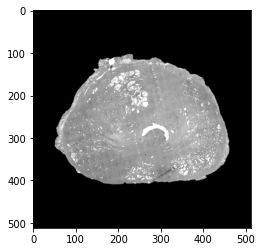

In [52]:
plt.imshow(centered_hist, cmap="gray")

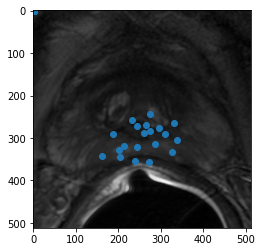

In [53]:
plt.imshow(centered_mri, cmap="gray")
plt.scatter(predicted_points[0, :, 1], predicted_points[0, :, 0] )

In [ ]:
np.sqrt(np.sum(np.abs(predicted_points - mri_points[:16]), axis=-1))

In [1]:
for i in range(10000):
    pow(2, 2**i, 7)

## Make New Pipeline

In [3]:
pipeline = HomologousPointPipeline("./homologous_point_prediction/outputs/att10_unmaskedgood/model", requires_scaling=True)

In [4]:
human_pipeline = HumanControlPointPipeline()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


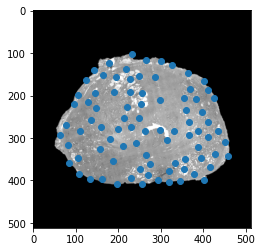

(512, 512)
(512, 512)
(85, 2)


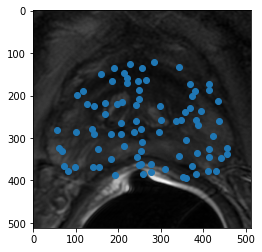

<Figure size 432x288 with 0 Axes>

In [5]:
data_dict = data_loader[1]
pipeline.fit(data_dict)
human_pipeline.fit(data_dict)

In [6]:
r = pipeline.warp_surface(data_dict["masked_mri"])
rh = human_pipeline.warp_surface(data_dict["masked_mri"])

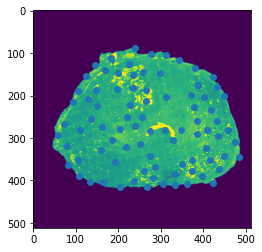

In [7]:
plt.imshow(data_dict["grayscale_hist"])
plt.scatter(pipeline.start_points[:, 1], pipeline.start_points[:, 0])

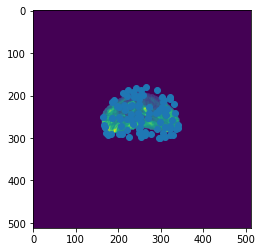

In [8]:
plt.imshow(data_dict["masked_mri"])
plt.scatter(pipeline.end_points[:, 1], pipeline.end_points[:, 0])

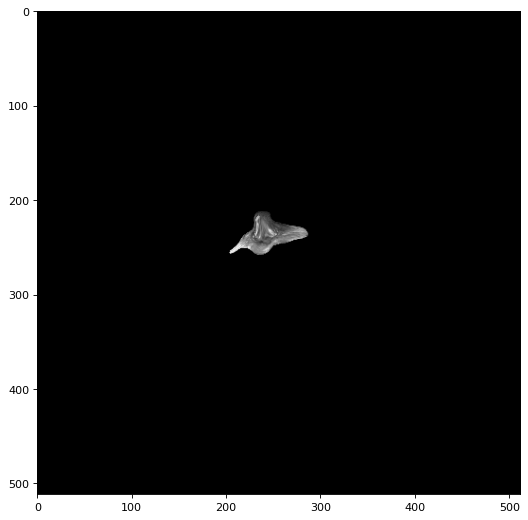

In [14]:
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(r, cmap="gray")

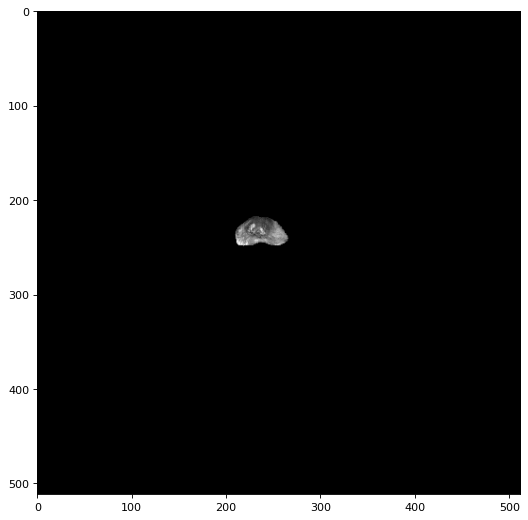

In [15]:
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(rh, cmap="gray")

In [ ]:
wi, wp = random_augmentation(data_dict['masked_mri'], data_dict['mri_points'])

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(wi)
plt.scatter(wp[:, 1], wp[:, 0])

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(data_dict['masked_mri'])
plt.scatter(data_dict['mri_points'][:, 1], data_dict['mri_points'][:, 0])

In [ ]:
pipline.fit(data_dict)

In [ ]:
result = pipline.warp_surface(data_dict["rgb_hist"])

## Visualize Inputs

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(data_dict["rgb_hist"])
plt.scatter(pipline.start_points[:, 1], pipline.start_points[:, 0])
plt.show()

## Show Results

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(data_dict["unmasked_mri"])
plt.scatter(pipline.end_points[:, 1], pipline.end_points[:, 0])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()

In [ ]:
import tensorflow as tf


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,
                 num_heads,
                 key_dim,
                 value_dim=None,
                 dropout=0.0,
                 use_bias=True,
                 output_shape=None,
                 attention_axes=None,
                 kernel_initializer="glorot_uniform",
                 bias_initializer="zeros",
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self._num_heads = num_heads
        self._key_dim = key_dim
        self._value_dim = value_dim if value_dim else key_dim
        self._dropout = dropout
        self._use_bias = use_bias
        self._output_shape = output_shape
        self._kernel_initializer = initializers.get(kernel_initializer)
        self._bias_initializer = initializers.get(bias_initializer)
        self._kernel_regularizer = regularizers.get(kernel_regularizer)
        self._bias_regularizer = regularizers.get(bias_regularizer)
        self._activity_regularizer = regularizers.get(activity_regularizer)
        self._kernel_constraint = constraints.get(kernel_constraint)
        self._bias_constraint = constraints.get(bias_constraint)
        if attention_axes is not None and not isinstance(attention_axes,
                                                         collections.abc.Sized):
            self._attention_axes = (attention_axes,)
        else:
            self._attention_axes = attention_axes
        self._built_from_signature = False
        self._query_shape, self._key_shape, self._value_shape = None, None, None

        def get_config(self):
            config = {
                "num_heads": self._num_heads,
                "key_dim": self._key_dim,
                "value_dim": self._value_dim,
                "dropout": self._dropout,
                "use_bias": self._use_bias,
                "output_shape": self._output_shape,
                "attention_axes": self._attention_axes,
                "kernel_initializer":
                    initializers.serialize(self._kernel_initializer),
                "bias_initializer":
                    initializers.serialize(self._bias_initializer),
                "kernel_regularizer":
                    regularizers.serialize(self._kernel_regularizer),
                "bias_regularizer":
                    regularizers.serialize(self._bias_regularizer),
                "activity_regularizer":
                    regularizers.serialize(self._activity_regularizer),
                "kernel_constraint":
                    constraints.serialize(self._kernel_constraint),
                "bias_constraint":
                    constraints.serialize(self._bias_constraint),
                "query_shape": self._query_shape,
                "key_shape": self._key_shape,
                "value_shape": self._value_shape,
            }
            base_config = super(MultiHeadAttention, self).get_config()
            return dict(list(base_config.items()) + list(config.items()))

        @classmethod
        def from_config(cls, config):
            # If the layer has a different build() function from the Keras default,
            # we need to trigger the customized build to create weights.
            query_shape = config.pop("query_shape")
            key_shape = config.pop("key_shape")
            value_shape = config.pop("value_shape")
            layer = cls(**config)
            if None in [query_shape, key_shape, value_shape]:
                logging.warning(
                    "One of dimensions of the input shape is missing. It should have been"
                    " memorized when the layer was serialized. "
                    "%s is created without weights.",
                    str(cls))
            else:
                layer._build_from_signature(
                    query_shape, value_shape, key_shape)  # pylint: disable=protected-access
            return layer

    def _build_from_signature(self, query, value, key=None):
        """Builds layers and variables.
        Once the method is called, self._built_from_signature will be set to True.
        Args:
          query: Query tensor or TensorShape.
          value: Value tensor or TensorShape.
          key: Key tensor or TensorShape.
        """
        self._built_from_signature = True
        if hasattr(query, "shape"):
            self._query_shape = tf.TensorShape(query.shape)
        else:
            self._query_shape = tf.TensorShape(query)
        if hasattr(value, "shape"):
            self._value_shape = tf.TensorShape(value.shape)
        else:
            self._value_shape = tf.TensorShape(value)
        if key is None:
            self._key_shape = self._value_shape
        elif hasattr(key, "shape"):
            self._key_shape = tf.TensorShape(key.shape)
        else:
            self._key_shape = tf.TensorShape(key)

        common_kwargs = dict(
            kernel_initializer=self._kernel_initializer,
            bias_initializer=self._bias_initializer,
            kernel_regularizer=self._kernel_regularizer,
            bias_regularizer=self._bias_regularizer,
            activity_regularizer=self._activity_regularizer,
            kernel_constraint=self._kernel_constraint,
            bias_constraint=self._bias_constraint)
        # Any setup work performed only once should happen in an `init_scope`
        # to avoid creating symbolic Tensors that will later pollute any eager
        # operations.
        with tf_utils.maybe_init_scope(self):
            free_dims = self._query_shape.rank - 1
            einsum_equation, bias_axes, output_rank = _build_proj_equation(
                free_dims, bound_dims=1, output_dims=2)
            self._query_dense = einsum_dense.EinsumDense(
                einsum_equation,
                output_shape=_get_output_shape(output_rank - 1,
                                               [self._num_heads, self._key_dim]),
                bias_axes=bias_axes if self._use_bias else None,
                name="query",
                **common_kwargs)
            einsum_equation, bias_axes, output_rank = _build_proj_equation(
                self._key_shape.rank - 1, bound_dims=1, output_dims=2)
            self._key_dense = einsum_dense.EinsumDense(
                einsum_equation,
                output_shape=_get_output_shape(output_rank - 1,
                                               [self._num_heads, self._key_dim]),
                bias_axes=bias_axes if self._use_bias else None,
                name="key",
                **common_kwargs)
            einsum_equation, bias_axes, output_rank = _build_proj_equation(
                self._value_shape.rank - 1, bound_dims=1, output_dims=2)
            self._value_dense = einsum_dense.EinsumDense(
                einsum_equation,
                output_shape=_get_output_shape(output_rank - 1,
                                               [self._num_heads, self._value_dim]),
                bias_axes=bias_axes if self._use_bias else None,
                name="value",
                **common_kwargs)

            # Builds the attention computations for multi-head dot product attention.
            # These computations could be wrapped into the keras attention layer once
            # it support mult-head einsum computations.
            self._build_attention(output_rank)
            self._output_dense = self._make_output_dense(
                free_dims, common_kwargs, "attention_output")

    def _make_output_dense(self, free_dims, common_kwargs, name=None):
        """Builds the output projection matrix.
        Args:
          free_dims: Number of free dimensions for einsum equation building.
          common_kwargs: Common keyword arguments for einsum layer.
          name: Name for the projection layer.
        Returns:
          Projection layer.
        """
        if self._output_shape:
            if not isinstance(self._output_shape, collections.abc.Sized):
                output_shape = [self._output_shape]
            else:
                output_shape = self._output_shape
        else:
            output_shape = [self._query_shape[-1]]
        einsum_equation, bias_axes, output_rank = _build_proj_equation(
            free_dims, bound_dims=2, output_dims=len(output_shape))
        return einsum_dense.EinsumDense(
            einsum_equation,
            output_shape=_get_output_shape(output_rank - 1, output_shape),
            bias_axes=bias_axes if self._use_bias else None,
            name=name,
            **common_kwargs)

    def _build_attention(self, rank):
        """Builds multi-head dot-product attention computations.
        This function builds attributes necessary for `_compute_attention` to
        costomize attention computation to replace the default dot-product
        attention.
        Args:
          rank: the rank of query, key, value tensors.
        """
        if self._attention_axes is None:
            self._attention_axes = tuple(range(1, rank - 2))
        else:
            self._attention_axes = tuple(self._attention_axes)
        self._dot_product_equation, self._combine_equation, attn_scores_rank = (
            _build_attention_equation(rank, attn_axes=self._attention_axes))
        norm_axes = tuple(
            range(attn_scores_rank - len(self._attention_axes), attn_scores_rank))
        self._softmax = advanced_activations.Softmax(axis=norm_axes)
        self._dropout_layer = core.Dropout(rate=self._dropout)

    def _masked_softmax(self, attention_scores, attention_mask=None):
        # Normalize the attention scores to probabilities.
        # `attention_scores` = [B, N, T, S]
        if attention_mask is not None:
            # The expand dim happens starting from the `num_heads` dimension,
            # (<batch_dims>, num_heads, <query_attention_dims, key_attention_dims>)
            mask_expansion_axis = -len(self._attention_axes) * 2 - 1
            for _ in range(len(attention_scores.shape) - len(attention_mask.shape)):
                attention_mask = tf.expand_dims(
                    attention_mask, axis=mask_expansion_axis)
        return self._softmax(attention_scores, attention_mask)

    def _compute_attention(self,
                           query,
                           key,
                           value,
                           attention_mask=None,
                           training=None):
        """Applies Dot-product attention with query, key, value tensors.
        This function defines the computation inside `call` with projected
        multi-head Q, K, V inputs. Users can override this function for customized
        attention implementation.
        Args:
          query: Projected query `Tensor` of shape `(B, T, N, key_dim)`.
          key: Projected key `Tensor` of shape `(B, T, N, key_dim)`.
          value: Projected value `Tensor` of shape `(B, T, N, value_dim)`.
          attention_mask: a boolean mask of shape `(B, T, S)`, that prevents
            attention to certain positions.
          training: Python boolean indicating whether the layer should behave in
            training mode (adding dropout) or in inference mode (doing nothing).
        Returns:
          attention_output: Multi-headed outputs of attention computation.
          attention_scores: Multi-headed attention weights.
        """
        # Note: Applying scalar multiply at the smaller end of einsum improves
        # XLA performance, but may introduce slight numeric differences in
        # the Transformer attention head.
        query = tf.multiply(query, 1.0 / math.sqrt(float(self._key_dim)))

        # Take the dot product between "query" and "key" to get the raw
        # attention scores.
        attention_scores = tf.einsum(self._dot_product_equation, key,
                                     query)

        attention_scores = self._masked_softmax(
            attention_scores, attention_mask)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training)

        # `context_layer` = [B, T, N, H]
        attention_output = tf.einsum(self._combine_equation,
                                     attention_scores_dropout, value)
        return attention_output, attention_scores

    def call(self,
             query,
             value,
             key=None,
             attention_mask=None,
             return_attention_scores=False,
             training=None):
        if not self._built_from_signature:
            self._build_from_signature(query=query, value=value, key=key)
        if key is None:
            key = value

        #   N = `num_attention_heads`
        #   H = `size_per_head`
        # `query` = [B, T, N ,H]
        query = self._query_dense(query)

        # `key` = [B, S, N, H]
        key = self._key_dense(key)

        # `value` = [B, S, N, H]
        value = self._value_dense(value)

        attention_output, attention_scores = self._compute_attention(
            query, key, value, attention_mask, training)
        attention_output = self._output_dense(attention_output)

        if return_attention_scores:
            return attention_output, attention_scores
        return attention_output
